
<div class="alert alert-info">
<font size="5"><b>Комментарий ревьюера</b></font>

Привет Максим! Меня зовут Марат, и я буду твоим ревьюером. Спешу сообщить что все ключевые этапы в работе выполнены,  с задачей тебе удалось справиться. По поводу обращения - в IT сфере принято общаться на «ты» :) Но, если привычней на «вы», дай знать. Как ревьюера моя задача помочь тебе в развитии, дав хорошие советы. Я внимательно посмотрю твой код, ознакомлюсь с твоими выводами и оставлю комментарии. Где то могу предложить небольшие исправление в коде, но ненавязчиво. Где потребуются уточнения, я оставлю много наводящих вопросов. Они помогут тебя с поиском верного решения.

Все мои комментарии размечены по цветам, для лучшего восприятия. 
    
<div class="alert alert-success">Зеленым цветом и словом «Успех» отмечены особо удачные и элегантные решения, которыми ты можешь гордиться. </div>
        
<div class="alert alert-warning">Желтым и значком словом «Совет», помечены решения у которых есть альтернативные решения, более оптимальные. Ты можешь найти их сразу и доработать проект, или отложить это на потом, для будущих проектах. Проект будет принят и без их доработки. </div>
        
<div class="alert alert-danger"> Красным цветом и значком словом «Ошибка» помечу твои решения, на которые стоит обратить внимание прежде всего. После их доработки проект будет принят. </div>
        
Залог успеха - работа сообща, взаимное уважение и работа в диалоге. Поэтому, помечай свои ответные комментарии на мои реплики заметным цветом или курсивом, так мне будет легче их отслеживать. Пожалуйста, не изменяй и не удаляй мои комментарии. Все это поможет выполнить повторную проверку быстрей.

</div>

<div class="alert alert-info">
<b>Комментарий студента</b> 
    
Привет! Спасибо что проверяешь мой проект и помогаешь сделать его лучше.
</div>

# Персонализация предложений интернет-магазина средствами МО

Руководство интернет-магазина "В один клик" поставило перед нашим отделом задачу - разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность. 

Руководитель отдела цифровых технологий уже сформулировал решение:
- Промаркировать уровень финансовой активности постоянных покупателей: «снизилась», если клиент стал покупать меньше товаров, или «прежний уровень».
- Собрать данные по клиентам по следующим группам:
 - Признаки, которые описывают коммуникацию сотрудников компании с клиентом.
 - Признаки, которые описывают продуктовое поведение покупателя. Например, какие товары покупает и как часто.
 - Признаки, которые описывают покупательское поведение клиента. Например, сколько тратил в магазине.
 - Признаки, которые описывают поведение покупателя на сайте. Например, как много страниц просматривает и сколько времени проводит на сайте.
 
В конечном итоге нам нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца, и, используя данные модели и данные о прибыльности клиентов, выделить сегменты покупателей и разработать для них персонализированные предложения.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Исследовательский-анализ" data-toc-modified-id="Исследовательский-анализ-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Исследовательский анализ</a></span><ul class="toc-item"><li><span><a href="#Распределение-количественных-признаков" data-toc-modified-id="Распределение-количественных-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Распределение количественных признаков</a></span></li><li><span><a href="#Выборка-клиентов-по-покупательской-активности" data-toc-modified-id="Выборка-клиентов-по-покупательской-активности-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Выборка клиентов по покупательской активности</a></span></li></ul></li><li><span><a href="#Объединение-таблиц" data-toc-modified-id="Объединение-таблиц-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Объединение таблиц</a></span></li><li><span><a href="#Корреляционный-анализ" data-toc-modified-id="Корреляционный-анализ-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Корреляционный анализ</a></span></li><li><span><a href="#Использование-пайплайнов" data-toc-modified-id="Использование-пайплайнов-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Использование пайплайнов</a></span></li><li><span><a href="#Анализ-важности-признаков" data-toc-modified-id="Анализ-важности-признаков-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Анализ важности признаков</a></span></li><li><span><a href="#Сегментация-покупателей" data-toc-modified-id="Сегментация-покупателей-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Сегментация покупателей</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

**Описание данных**

1. `market_file.csv` - данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
 - id — номер покупателя в корпоративной базе данных.
 - Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
 - Тип сервиса — уровень сервиса, например «премиум» и «стандарт».
 - Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это  даёт покупатель.
 - Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
 - Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.
 - Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
 - Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
 - Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.
 - Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
 - Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.
 - Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.
 - Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.


2. `market_money.csv` - данные о выручке, которую получает магазин с покупателя, сколько покупатель всего потратил за период взаимодействия с сайтом.
 - id — номер покупателя в корпоративной базе данных.
 - Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
 - Выручка — сумма выручки за период.


3. `market_time.csv` - данные о времени (в минутах), которое покупатель провёл на сайте в течение периода.
 - id — номер покупателя в корпоративной базе данных.
 - Период — название периода, во время которого зафиксировано общее время.
 - минут — значение времени, проведённого на сайте, в минутах.


4. `money.csv` - данные о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.
 - id — номер покупателя в корпоративной базе данных.
 - Прибыль — значение прибыли.

**Для дальнейшей работы нам необходимо установить библиотеки phik и shap**

In [1]:
import pandas as pd # Импорт необходимых библиотек
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np

from sklearn.pipeline import Pipeline # Инструменты для работы с пайплайнами
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler # Кодировщики, скейлеры
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute import SimpleImputer

from sklearn.metrics import f1_score, roc_auc_score, RocCurveDisplay # Метрики, методы анализа важности признаков

from sklearn.svm import SVC # Модели-классификаторы
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

try:
    OneHotEncoder(sparse_output=False) # Это лютый костыль, но в данной ситуации должно работать xD
except:
    !pip install -U scikit-learn 

try:
    import shap
except:
    !pip install shap
    import shap

try: # Библиотек phik и shap нету в окружении практикума по умолчанию. Использую конструкцию try-except при импорте
    import phik
except:
    !pip install phik
    import phik

<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюера</b></font>



Совет 🤔:


Лучший в случае except 
    
    !pip install phik
    import phik
    
    
    

<div class="alert alert-info">
<b>Комментарий студента</b> 
    
Изменил конструкции try-except для phik и shap. Добавил ещё одну для обновления sklearn.  
p.s. Немного путает, что в окружении нету всех библиотек, нужных для проекта. Ну да ладно, для нас это не преграда.
</div>

In [2]:
import warnings # Отключаем предупреждения о будущих версиях библиотек(версии для проекта обновляться не будут)
warnings.filterwarnings("ignore", category=FutureWarning)

sns.set_style('dark') # Устанавливаем стиль для графиков
RANDOM_STATE = 38 # Константа определения случайных значений

## Загрузка данных

In [3]:
def dataset_info(ds, info=True): # Универсальная функция презентации данных
    print('Количество дубликатов:', ds.duplicated().sum())
    print('Длина датасета:', len(ds))
    display(ds.head())
    if info: 
        ds.info()
        display(ds.describe())

Для начала загрузим данные и ознакомимся с ними.

In [4]:
try: # Проект запускается либо в окружении практикума, либо локально. 
    ds_main = pd.read_csv('/datasets/market_file.csv')
except:
    ds_main = pd.read_csv('datasets/market_file.csv')
dataset_info(ds_main)

Количество дубликатов: 0
Длина датасета: 1300


,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


Ни одного явного дубликата. Названия столбцов вполне информативны, разве-что привести их к нижнему регистру. Тип сервиса "стандартт" вызывает подозрения, возможно это ошибка заполнения или дубликат значения. Отложим это на этап предобработки. Всем данным уже присвоен соответствующий тип. В целом можно сказать, что данные в хорошем состоянии.

In [5]:
try: 
    ds_money = pd.read_csv('/datasets/market_money.csv')
except:
    ds_money = pd.read_csv('datasets/market_money.csv')
dataset_info(ds_money)

Количество дубликатов: 0
Длина датасета: 3900


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


,id,Выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


Никаких дубликатов, значения соответствуют ожидаемым. В датасете значительно больше записей, 3900 против 1300 из основного датасета. Это связано с тем, что здесь представлены несколько периодов для каждого айди.

In [6]:
try: 
    ds_time = pd.read_csv('/datasets/market_time.csv')
except:
    ds_time = pd.read_csv('datasets/market_time.csv')
dataset_info(ds_time)

Количество дубликатов: 0
Длина датасета: 2600


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


,id,минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


Похожая ситуация, записей больше из-за нескольких периодов. Видна грамматическая ошибка в значении "предыдцщий_месяц". Запомнили.

In [7]:
try: 
    ds_mean_money = pd.read_csv('/datasets/money.csv', sep=';', decimal=",")
except:
    ds_mean_money = pd.read_csv('datasets/money.csv', sep=';', decimal=",")
dataset_info(ds_mean_money)

Количество дубликатов: 0
Длина датасета: 1300


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


,id,Прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


Среднее значение среднемесячной прибыли за последние 3 месяца - 4. Кажется, это не рубли, а как минимум тысячи рублей. Этот момент стоит уточнить у тех, кто составлял данные. Пока будем отталкиваться от предположения, что прибыль указывается в тысячах рублей. В остальном с данными всё в порядке, количество записей совпадает с основным датасетом. На этом можно заканчивать загрузку данных и переходить к следующему этапу.

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:

Данные изучены
    
    
- данные загружены корректно
    

	
- предварительный обзор данных сделан

   
<div class="alert alert-warning">
 

Совет 🤔:
    

 
- сейчас это не нужно (пока лучше вручную набивать все эти .info, count_values, .describe, .diplicate...) но в будущем можешь обратить внимание на библиотечки, в которых уже собран необходимый минимум при EDA (и не только минимум), например [ydata_profiling](https://docs.profiling.ydata.ai/4.5/) или [pandas_profiling](https://habr.com/ru/companies/ruvds/articles/451478/) - будет информативно и красиво. 




    
    



<div class="alert alert-info">
<b>Комментарий студента</b> 
    
Принял, спасибо
</div>

## Предобработка данных

Для начала - приведём все названия столбцов к нижнему регистру для удобства.

In [8]:
ds_main.columns = ds_main.columns.str.lower().str.replace(' ', '_')
ds_money.columns = ds_money.columns.str.lower().str.replace(' ', '_')
ds_time.columns = ds_time.columns.str.lower().str.replace(' ', '_')
ds_mean_money.columns = ds_mean_money.columns.str.lower().str.replace(' ', '_')
print(ds_main.columns, ds_money.columns, ds_time.columns, ds_mean_money.columns)

Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object') Index(['id', 'период', 'выручка'], dtype='object') Index(['id', 'период', 'минут'], dtype='object') Index(['id', 'прибыль'], dtype='object')



    
    
<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюера</b></font>


Совет: 


А забыл организовать нижнее подчеркивание между словами,  и убрать ненужные символы если они есть.  Для этого можно использовать  регуляризацию    (или .rename). Пример регулярного выражения:  
     
	df.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in df.columns]
     


Кроме того существует удобная библиотека для выполнения рутинных операций в пандасе, называемая [skimpy](https://pypi.org/project/skimpy/), в этой библиотеке доступна функция clean_column(), которая позволяет легко привести названия столбцов к соответствующему формату в одно действие. Но это уже для случаев когда название столбцов нам даны на латинице     
     


<div class="alert alert-info">
<b>Комментарий студента</b> 
    
Пока решил просто добавить замену пробелов на нижнее подчёркивание, но учту.
</div>

Теперь пройдёмся по подозрительным значениям, которые нам удалось заметить. Например, тип сервиса "стандартт". На всякий случай посмотрим на уникальные значения всех категориальных столбцов.

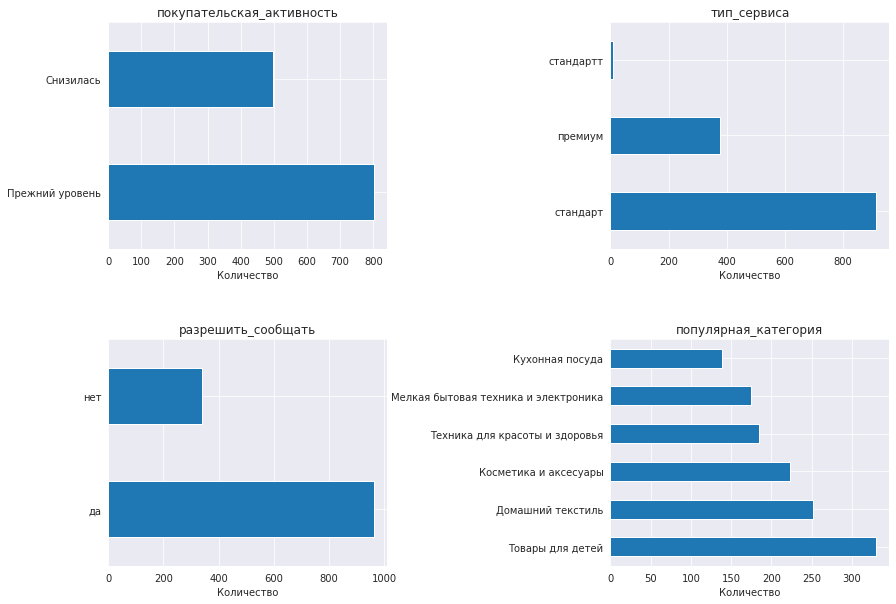

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=2)
j=0
for i in ds_main.select_dtypes(exclude='number').columns:
    ds_main[i].value_counts().plot(kind='barh', figsize=(14, 10), ax=axes[j//2, j%2], grid=True)
    axes[j//2, j%2].set_title(i)
    axes[j//2, j%2].set_xlabel('Количество')
    j+=1
plt.subplots_adjust(wspace=0.8, hspace=0.4)
plt.show()

Да, значение "стандартт" - неявный дубликат значения "стандарт". В остальных столбцах неявных дубликатов нет. Заодно можно заметить явный дисбаланс классов целевого признака - гораздо больше клиентов, чья покупательская способность осталась на прежнем уровне.

In [10]:
ds_main.loc[ds_main['тип_сервиса'] == 'стандартт', 'тип_сервиса'] = 'стандарт'
ds_main['тип_сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

Раз-уж заговорили про категориальные параметры - посмотрим на столбцы с периодами из `ds_time` и `ds_money`.

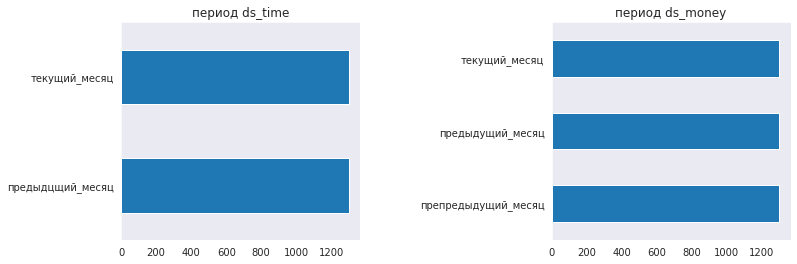

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2)
ds_time['период'].value_counts().plot(kind='barh', figsize=(12, 4), title='период ds_time', ax=axes[0])
ds_money['период'].value_counts().plot(kind='barh', figsize=(12, 4), title='период ds_money', ax=axes[1]);
plt.subplots_adjust(wspace=0.8)

А это уже простая ошибка наименования. Исправим её

In [12]:
ds_time.loc[ds_time['период'] == 'предыдцщий_месяц', 'период'] = 'предыдущий_месяц'
ds_time['период'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

И на этом предобработку можно заканчивать. Мы привели названия столбцов к нижнему регистру, избавились от двух неявных дубликатов в данных, а также выявили дисбаланс классов.

    
<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>



Успех:


    
- Здорово что обращено внимание на  скрытые дубликаты    и опечатки 
    

  


<div class="alert alert-warning">

Совет: 



- можно еще поискать опечатки, их тут хватает (кстати повлияют ли они  на работу модели?)

  
- можешь предложить как можно искать такие описки и скрытые дубликаты автоматически? 


<div class="alert alert-info">
<b>Комментарий студента</b> 
    
Если название всей категории изначально написано с ошибкой - на работу модели это не повлияет, а вот если из опечатки выделится отдельная категория - вполне может.
    
Объектов в категориях-дубликатах обычно встречается немного. Можно отсеивать категории, в которых встречается менее 5% записей.
</div>

## Исследовательский анализ

### Распределение количественных признаков

Для начала проанализируем основной датасет. Распределение категориальных признаков мы уже смотрели при выявлении неявных дубликатов, теперь посмотрим на распределение количественных признаков.

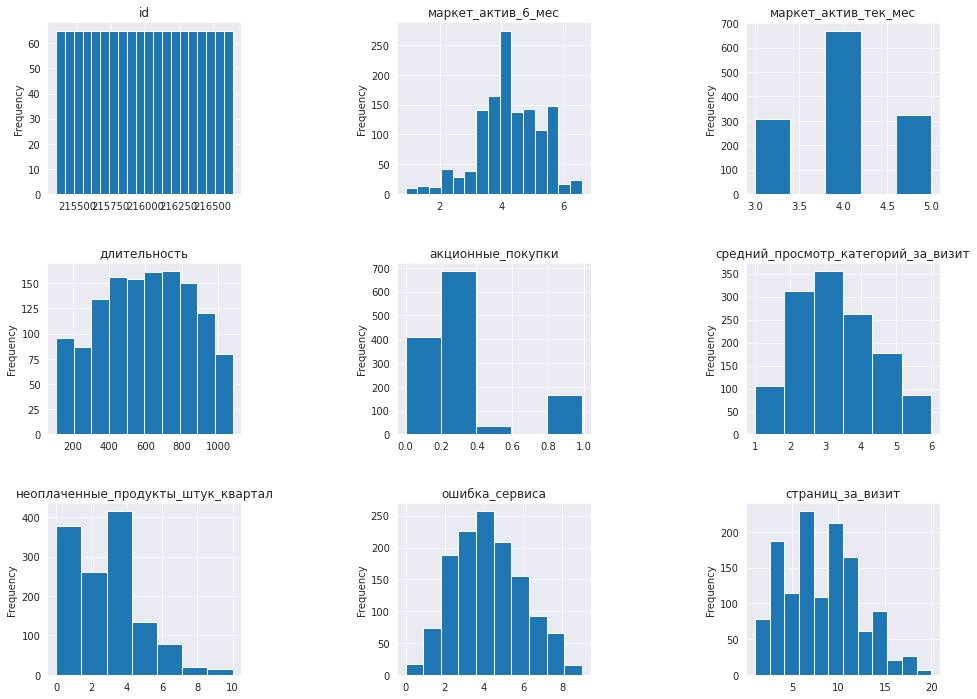

In [13]:
fig, axes = plt.subplots(nrows=3, ncols=3)
j=0
bins=[20, 15, 5, 10, 5, 6, 7, 10, 12]
for i in ds_main.select_dtypes(include='number').columns:
    ds_main[i].plot(kind='hist', bins=bins[j], ax=axes[j//3, j%3], figsize=(16, 12), grid=True)
    axes[j//3, j%3].set_title(i)
    j+=1

plt.subplots_adjust(wspace=0.8, hspace=0.4)
plt.show()

`id` распределены равномерно и последовательно, записи в выборку явно выбирались не случайным образом, это может быть как хорошо по причине сравнительно одинаковой свежести данных, так и плохо по причине возможного наличия в выборке закономерностей, которых нету в генеральной совокупности.

Отдел маркетинга не зря получает зарплату - в среднем производится от 3 до 6 маркетинговых коммуникаций с абсолютным большинством клиентов каждый месяц из числа последних шести, и текущий месяц показывает схожую картину. Отсутствие нулевых значений в текущем месяце выглядит подозрительно, но не невозможно.

Признак `акционные_покупки` показывает, что клиенты разбились на 2 условных лагеря - основной, совершающий от 0 до 40% акционных покупок, и чуть менее крупный, которые совершают исключительно покупки товаров по акции - от 80 до 100%.

`неоплаченные_продукты` перекошены влево, большинство старается оплачивать как можно больше своих покупок.

Все остальные распределения похожи на нормальное.

Теперь взглянем на данные из остальных таблиц.

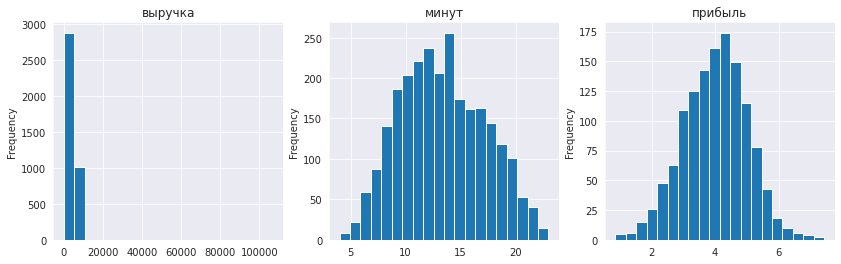

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=3)
j=0
for i in [ds_money['выручка'], ds_time['минут'], ds_mean_money['прибыль']]:
    i.plot(kind='hist', bins=20, figsize=(14, 4), ax=axes[j], title=i.name, grid=True)
    j+=1

А вот и первая аномалия. Выручка за один из месяцев свыше 100.000

In [15]:
ds_money[ds_money['выручка']>80000]

,id,период,выручка
98,215380,текущий_месяц,106862.2


Не исключено, что такой клиент действительно существует, но при обучении модели он будет нам мешать.

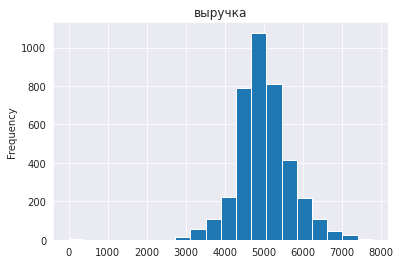

In [16]:
ds_money = ds_money[ds_money['выручка']<100000]
ds_money['выручка'].plot(kind='hist', bins=20, title='выручка', grid=True);

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>



Успех 👍:



👍


 

Теперь все распределения выглядят нормально.

Посмотрим также на ящиковые диаграммы.

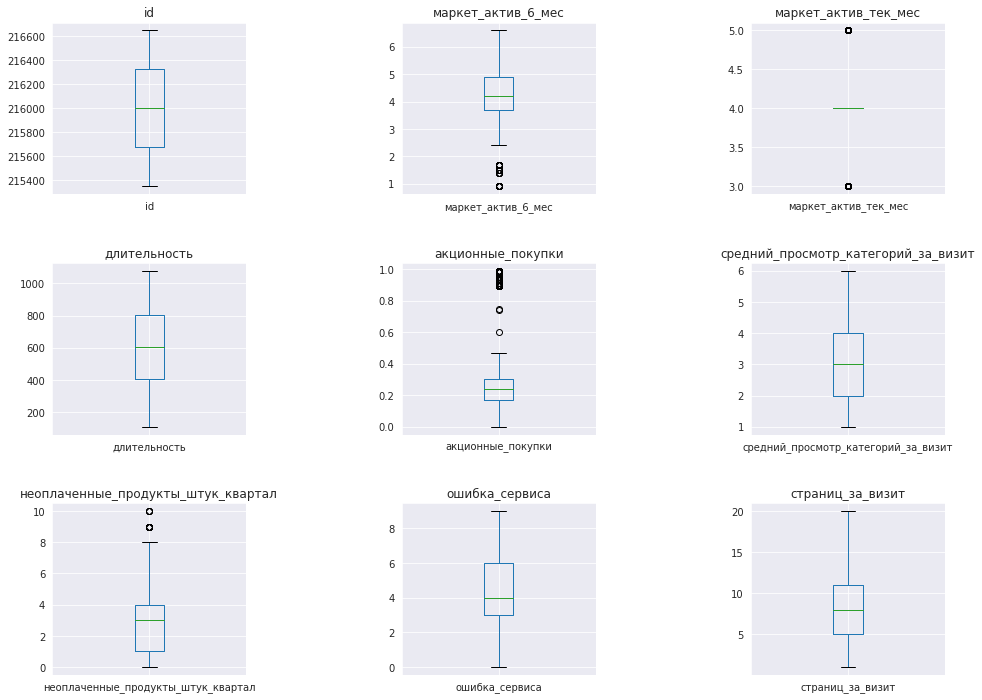

In [17]:
fig, axes = plt.subplots(nrows=3, ncols=3)
j=0
for i in ds_main.select_dtypes(include='number').columns:
    ds_main[i].plot(kind='box', ax=axes[j//3, j%3], figsize=(16, 12), grid=True)
    axes[j//3, j%3].set_title(i)
    j+=1

plt.subplots_adjust(wspace=0.8, hspace=0.4)
plt.show()

Есть несколько записей с крайне низкой маркетинговой активностью за 6 месяцев. За текущий месяц есть только значения 3, 4 или 5, что уже больше смахивает на категории. В акционных покупках группа аномально высоких значений - это клиенты, которые покупают в основном товары по акции. И пара аномалий в неоплаченных продуктах. Ничего такого о чём стоило-бы беспокоиться.

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>



Успех 👍:



👍subplots


Хорошо когда графики размещены компактно 

### Выборка клиентов по покупательской активности

Теперь найдём клиентов, которые в течение последних трёх месяцев совершали хотя-бы одну покупку каждый месяц. 

In [18]:
ds_money_new = ds_money.set_index('id') # Устанавливаем айди как индекс
for i in ds_money_new['период'].unique(): # Для каждого уникального периода создаётся новый столбец
    ds_money_new[i] = ds_money_new.loc[ds_money_new['период'] == i, 'выручка']
ds_money_new['id'] = ds_money_new.index # Защита от сброса похожих записей. Временно возвращаю айди перед сбросом дубликатов
ds_money_new = ds_money_new.drop(['период', 'выручка'], axis=1).drop_duplicates().replace(0, np.nan).dropna()
ds_money_new = ds_money_new.drop(['id'], axis=1)
ds_money_new.columns = ds_money_new.columns+'_выручка'
dataset_info(ds_money_new, False) # Убираем ненужные столбцы, сбрасываем дубликаты, заменяем нули на nan и сбрасываем пропуски.

Количество дубликатов: 21
Длина датасета: 1296


,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_выручка
id,,,
215349,4472.0,4971.6,5216.0
215350,4826.0,5058.4,5457.5
215351,4793.0,6610.4,6158.0
215352,4594.0,5872.5,5807.5
215353,5124.0,5388.5,4738.5


А вот и действующие клиенты, а заодно и выручка в каждом месяце от них. Дальше на очереди объединение таблиц.

## Объединение таблиц

Данные о выручке уже готовы. Проведём такую-же подготовку для данных с временем посещения сайта

In [19]:
ds_time_new = ds_time.set_index('id') # Всё то-же самое, что и в ячейке выше, но для другой таблицы
for i in ds_time_new['период'].unique():
    ds_time_new[i] = ds_time_new.loc[ds_time_new['период'] == i, 'минут']
ds_time_new['id'] = ds_time_new.index
ds_time_new = ds_time_new.drop(['период', 'минут'], axis=1).drop_duplicates()
ds_time_new = ds_time_new.drop(['id'], axis=1)
ds_time_new = ds_time_new[ds_time_new.index.isin(ds_money_new.index)] # Оставляю только записи, чей айди уже присутствует в ds_money_new
ds_time_new.columns = ds_time_new.columns+'_минут'
dataset_info(ds_time_new, False)

Количество дубликатов: 1018
Длина датасета: 1296


,текущий_месяц_минут,предыдущий_месяц_минут
id,,
215349,10,12
215350,13,8
215351,13,11
215352,11,8
215353,10,10


А теперь - объединим таблицы в одну.

In [20]:
ds_new = ds_main[ds_main['id'].isin(ds_money_new.index)].set_index('id')
ds_new = ds_new.join(ds_money_new).join(ds_time_new)
dataset_info(ds_new, False)

Количество дубликатов: 11
Длина датасета: 1296


,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_выручка,текущий_месяц_минут,предыдущий_месяц_минут
id,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,4971.6,5216.0,10,12
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5058.4,5457.5,13,8
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6610.4,6158.0,13,11
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4594.0,5872.5,5807.5,11,8
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5124.0,5388.5,4738.5,10,10


Это было быстро(сравнительно). В следующем этапе посмотрим на корреляцию признаков.

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>



Успех 👍:



- данные для моделирования подготовлены

  

<div class="alert alert-warning">


Совет 🤔:



 
- альтернатива использовать [pivot_table](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html) - продвинутый инструмент, позволяющий делать в том числе агрегацию (по умолчанию считает среднюю), также  подошли бы инструменты попроще  pivot или set_index + unstack. Стоит поискать уже готовое решение, а не писать фукции или циклы. Кроме того часто  такого рода решения написано на языке С, а значит они оптимальны с точки зрения скорости
 

 

## Корреляционный анализ

Для начала посмотрим на матрицу корреляции Спирмена(Не все признаки имеют нормальное распределение)

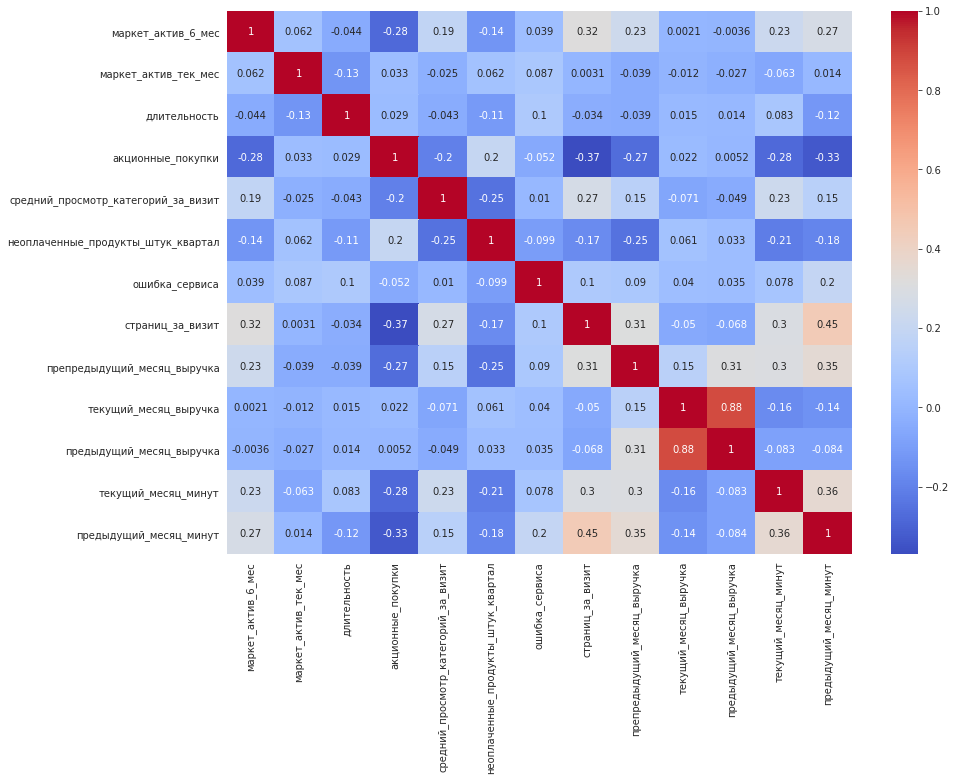

In [21]:
plt.figure(figsize=(14, 10))
sns.heatmap(ds_new.corr(method='spearman'), annot=True, cmap='coolwarm');


<div class="alert alert-danger">
<font size="5"><b>Комментарий ревьюера</b></font>



Ошибка ❌:



Тут лучше использовать Спирмена, ведь по гистограммам очевидно что не все признаки имеют нормальное распределение



<div class="alert alert-warning">


Совет: 


- можно поменять политру для удобства восприятия, через добавление cmap='coolwarm' ('bwr', 'seismic'), тогда чем ближе корреляция к 1 тем красней, чем ближе к -1 тем "синей" , ну и чем меньше связи, чем ближе к 0, тем нейтальней цвет


<div class="alert alert-info">
<b>Комментарий студента</b> 
    
Поменял метод расчёта корреляции, изменил цветовую палитру хитмапов.
</div>

Выручка за текущий и предыдущий месяц сильно коррелируют. На границе мультиколлинеарности.

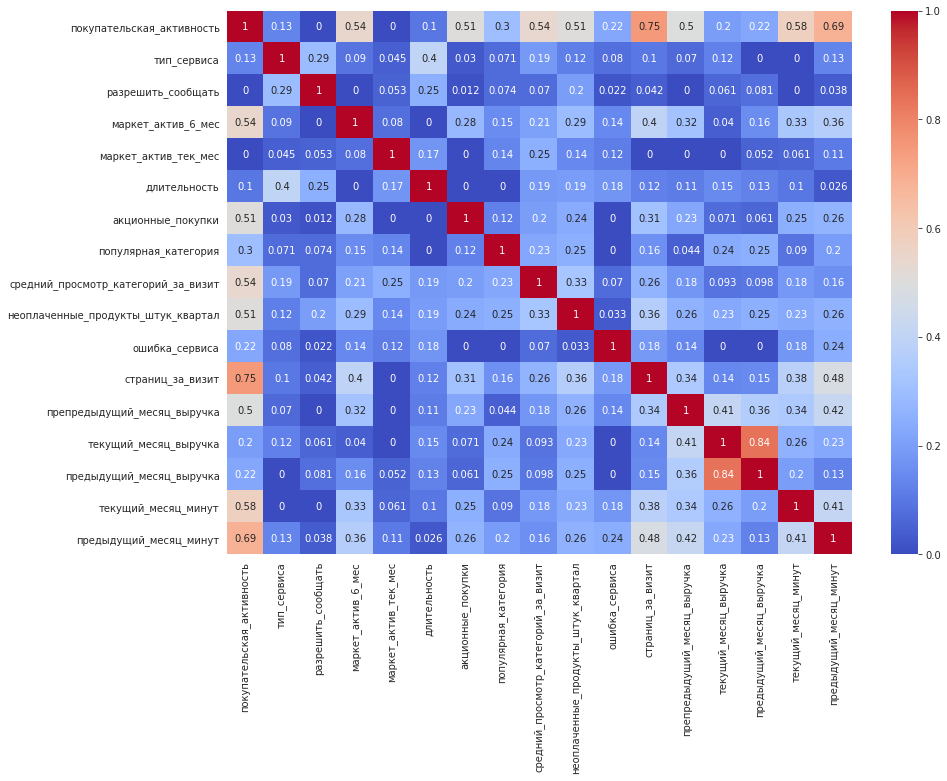

In [22]:
plt.figure(figsize=(14, 10))
sns.heatmap(ds_new.phik_matrix(interval_cols=ds_new.select_dtypes(include='number').columns), annot=True, cmap='coolwarm');

Количество страниц за визит и минут, проведённых на сайте, сильно влияют на покупательскую активность. 

Возможно у записей с разными значениями целевого признака имеются разные закономерности? Посмотрим на 2 матрицы корреляции со сниженной и прежней покупательской активностью.

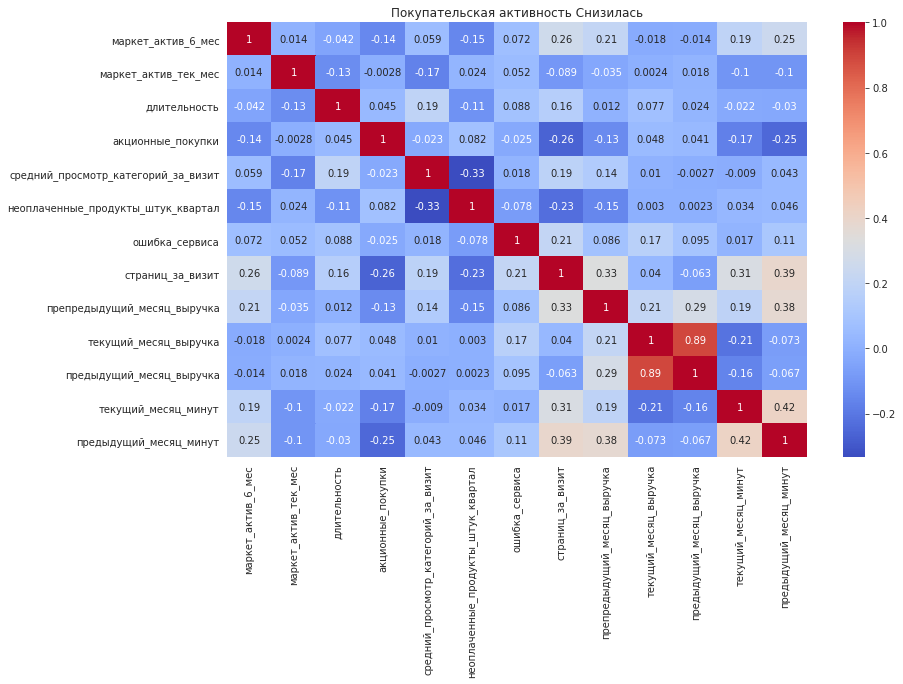

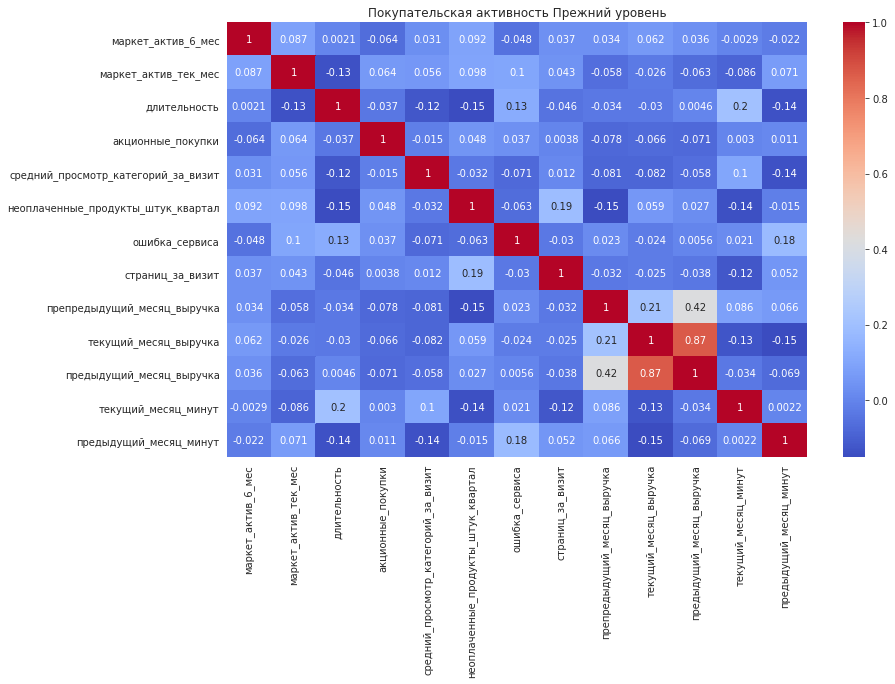

In [23]:
for i in ds_new['покупательская_активность'].unique():
    plt.figure(figsize=(13, 8))
    sns.heatmap(ds_new[ds_new['покупательская_активность']==i].corr(method='spearman'), annot=True, cmap='coolwarm')
    plt.title(f'Покупательская активность {i}')

На прежнем уровне покупательской активности можем поймать слабую корреляцию между выручкой за предыдущий месяц и препредыдущий.

А на сниженном уровне активности, кажется, слабо коррелирует всё и со всем. Слабая корреляция между временем, проведенном на сайте за текущий и предыдущий месяц. Точно такая-же корреляция между временем на сайте за предыдущий месяц и количеством страниц за визит с выручкой за препредыдущий месяц. И так далее в том-же духе. Мультиколлинеарностью это не назвать, но взаимосвязь в данных покупателей со сниженной активностью явно имеется


<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>



Успех 👍:



👍 phik_matrix


 




<div class="alert alert-warning">


Совет: 

 
- используя phik_matrix  лучше вручную указать столбцы с количественными признаками через  [interval_cols](https://dzen.ru/a/ZEtcuc4K2RX_Jstr)   

- можно построить дополнительно  матрицы корреляций для двух датасетов разбитых по таргету. Затем проанализировать есть ли отличия в корреляции, это может быть полезно для лучшего понимания нашей данных
 
   

<div class="alert alert-info">
<b>Комментарий студента</b> 
    
Указал interval_cols для phik_matrix. Построил 2 матрицы для уникальных значений покупательской активности.
</div>

Теперь перейдём к анализу распределений. Начнём с категориальных признаков.

<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюера</b></font>



Совет 🤔:


Можно было оставить как есть,  ведь это проблема только для линейных моделей.  А для сегментации - эта информация могла нам пригодиться 

<div class="alert alert-info">
<b>Комментарий студента</b> 
    
Убрал удаление признака.
</div>

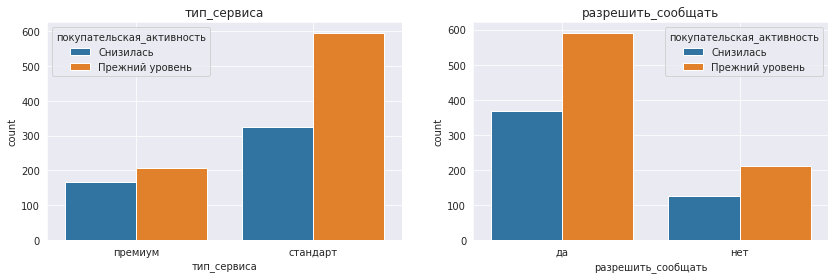

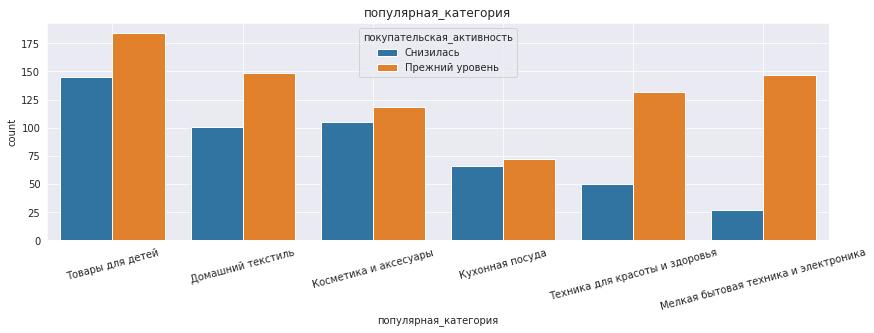

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
j=0

for i in ['тип_сервиса', 'разрешить_сообщать']:
    sns.countplot(data=ds_new, x=i, hue='покупательская_активность', ax=axes[j])
    axes[j].set_title(i)
    axes[j].grid()
    j+=1
plt.show()

plt.figure(figsize=(14, 4))
plt.xticks(rotation=15)
plt.title('популярная_категория')
sns.countplot(data=ds_new, x='популярная_категория', hue='покупательская_активность');
plt.grid()

Небольшой перекос у типа сервиса, у клиентов с сервисом типа премиум в процентном соотношении чаще снижается покупательская активность. 

Согласие на рассылку мало влияет на целевой признак. 

А вот в популярной категории разница разительная. В группе риска у нас клиенты, предпочитающие покупать кухонную посуду или косметику. А у фанатов бытовой техники или техники для красоты наоборот реже снижается покупательская активность.

На категориальные признаки посмотрели, теперь взглянем на зависимость целевого признака от числовых.

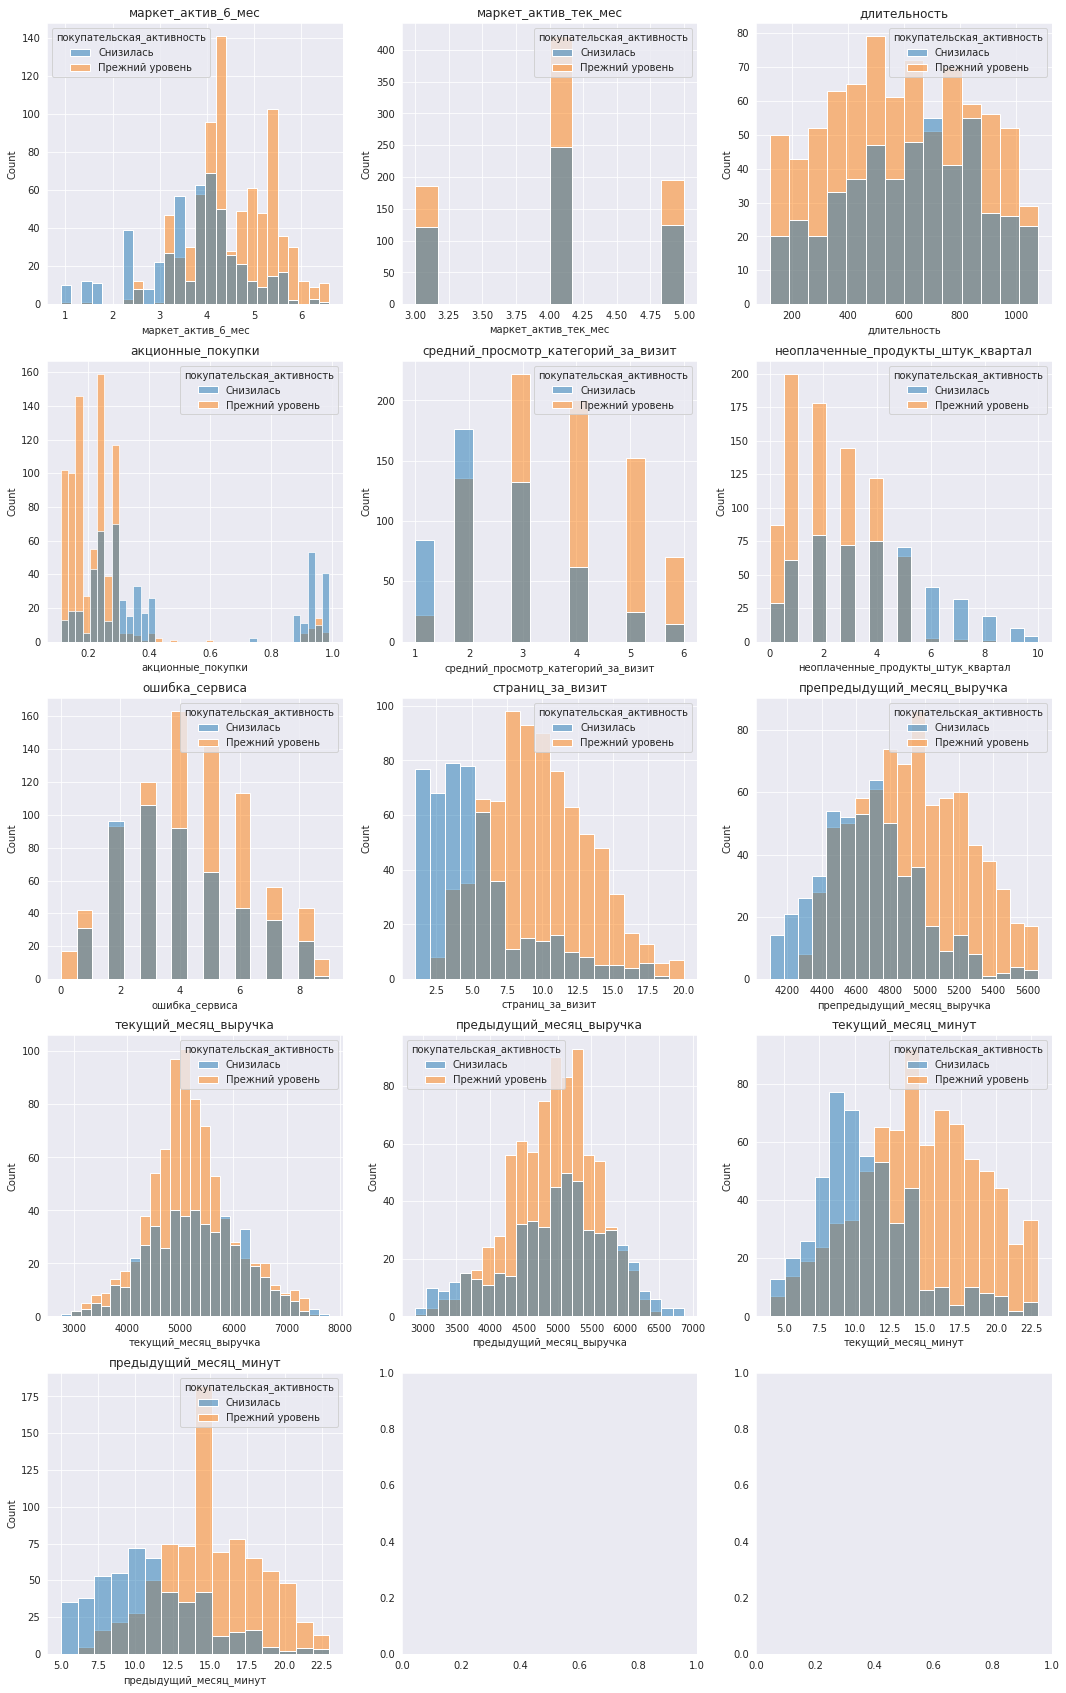

In [25]:
fig, axes = plt.subplots(ncols=3, nrows=5, figsize=(18, 30))
j=0
# Гистограмма строится для каждого столбца с числовыми данными, выделяя категории покупательской активности
for i in ds_new.select_dtypes(include = 'number').columns:
    sns.histplot(data=ds_new, x=i, hue='покупательская_активность', ax=axes[j//3, j%3])
    axes[j//3, j%3].set_title(i)
    axes[j//3, j%3].grid()
    j+=1
plt.show()

Видны явные закономерности между целевым признаком и:
- Акционными покупками;
- Средним просмотром категорий за визит;
- Неоплаченными продуктами;
- Страницами за визит;
- Выручкой в позапрошлом месяце;
- Минутами, проведёнными на сайте за текущий и предыдущий месяц.


<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>



Успех 👍:



Отличные графики,  здорово Что используешь seaborn.  Отдельный плюс за разбивку по Таргет


 

<div class="alert alert-warning">
 
Совет 🤔:



- Только я ждал увидеть эти графики в разделе выше


В прошлом проекте мы активно использовали scatter_plot для уточнения характера связи между признаками и удоем, и на основе увиденного сделали некоторые преобразования, помогающие преодолеть ограничения линейной модели. В этом проекте мы используем нелинейные модели для которых это не проблема, и таргет у нас не количественный а категориальный. Тем не менее и в этом проекте можно построить scatter_plot между количественными признаками, а таргет использовать  в качестве фильтра. Напомню что проще всего это реализовать с помощью [sns.PairGrid](https://seaborn.pydata.org/generated/seaborn.PairGrid.html). Это не пригодится нам для улучшения метрики, но возможно мы увидим что то полезное для сегментации или лучшего понимания наших данных. 

- Можно c помощью scatter_plot сконцентрироваться на связи между выручка текущая - выручка за прошлый. Там явная линейная зависимость, причем как будто бы множество точек тяготеют к двум прямым. Можно поискать факторы которые описывает эти два разных множества. Можно к выручке за прошлый месяц добавить выручку за позапрошлый месяц (или отнять) и тогда в каких то группировках по категориальным признакам будет очень четкая линейная зависимость достигающая по r2 за 0.9. Из этого можно сделать вывод что  в определенных группировках, зависимость между выручками за разные периоды практически дерерминирована (очень высокий показатель r2), то есть из выручки за прошлый (и с учетом позапрошлого месяца) мы можем точно спрогнозировать расходы клиента за текущий месяц. О чем это может говорить? 



- Можно посмотреть scatter_plot между id и акционными покупками. Можно кое что интересное увидеть и дать этому обьяснение


## Использование пайплайнов

Целевой признак `покупательская активность` - бинарный. Для удобства заменим `Снизилась` на 1, а `Прежний уровень` на 0.

In [26]:
ds_new.loc[ds_new['покупательская_активность'] == 'Снизилась', 'покупательская_активность'] = 1
ds_new.loc[ds_new['покупательская_активность'] == 'Прежний уровень', 'покупательская_активность'] = 0
ds_new['покупательская_активность'] = pd.to_numeric(ds_new['покупательская_активность'])

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>



Успех 👍:



👍 Верно определил положительный класс


 

Теперь разделим данные на выборки. Покупательская активность - целевой признак, его и будем прогнозировать.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    ds_new.drop('покупательская_активность', axis=1), 
    ds_new['покупательская_активность'], 
    random_state=RANDOM_STATE, 
    stratify=ds_new['покупательская_активность']
)

Дальше создадим пайплайны для подготовки данных

In [28]:
encode_pipe = Pipeline([
    ('encode', OneHotEncoder(drop='first', sparse_output=False)),
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])

<div class="alert alert-danger">
<font size="5"><b>Комментарий ревьюера</b></font>

Ошибка:

Вылетает ошибка     
    
    TypeError: __init__() got an unexpected keyword argument 'sparse'


    
Стоит перед отправкой проекта перезапустить ядро и выполнить все ячейки – так можно проверить, что код работает:
    
<img src='https://jing.yandex-team.ru/files/aslvova/Screenshot%202022-05-31%20at%2011.08.40.png' alt='restart_kernel_and_run_all' width='400'>

Не знаю какая картинка откроется...

![](https://i.postimg.cc/yd19rYf6/Screenshot-428.png)





<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюера</b></font>
 

Совет 🤔:


Полагаю проблема в том что ты используешь устаревшую версию библиотеки. Стоит обновить.  Пишем  
    
    
 
    
    !pip install -U scikit-learn    
    
Перезапускаем ядро и используем
    
    
    sparse  ------>  sparse_output
    
    
И
    
    get_feature_names  ----->  get_feature_names_out

<div class="alert alert-info">
<b>Комментарий студента</b> 
    
Поправил. Добавил обновление sklearn в импорты.
</div>

In [29]:
encode_columns = X_train.select_dtypes(exclude='number').columns
num_columns = X_train.select_dtypes(include='number').columns
data_preprocessor = ColumnTransformer(
    [
        ('encode', encode_pipe, encode_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)
print(encode_columns)
print(num_columns)

Index(['тип_сервиса', 'разрешить_сообщать', 'популярная_категория'], dtype='object')
Index(['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит', 'препредыдущий_месяц_выручка',
       'текущий_месяц_выручка', 'предыдущий_месяц_выручка',
       'текущий_месяц_минут', 'предыдущий_месяц_минут'],
      dtype='object')


И объединим подготовку с самим обучением.





<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюера</b></font>



Совет 🤔:
    
    
    
    encode_columns = X_train.select_dtypes(exclude='number').columns
    num_columns = X_train.select_dtypes(include='number').columns    
    
    
После этого лучше всё-таки вывести их на печать,  так будет больше контроля    
    

В будущем при предобработке данных можешь учитывать следующие моменты:

    
- если у категориального признака большое количество уникальных значений, применение One-Hot Encoding может привести к большому количеству новых признаков, это усложнит работу моделей
    
- у catboost и lighgbm есть собственные инструменты работы с категориальными данными, нужно только указать какие столбца содержат категориальные данные
    
- при работе с количественными признаками для линейных и метрических (модели в которых измеряется расстояние) моделей  обязательно делаем Scaler, в отличие от моделей на основе деревьев решений, для них Scaler не нужен
        

Можешь подумать над вопросом почему для линейных моделей некорректное использование OrdinalEncoder может вызвать больше проблем чем для случайного леса  или других моделей в основе которых лежат деревья решений   


<div class="alert alert-info">
<b>Комментарий студента</b> 
    
Добавил вывод после присвоения
    
Учитывая, что линейные модели ищут линейные взаимосвязи, они будут искать зависимость в последовательных значениях от OrdinalEncoder, которой может и не быть.
</div>

In [30]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

Теперь создадим матрицу гиперпараметров. Возьмём за основу 4 модели - дерево решений, к-ближайших соседей, метод опорных векторов и логистическую регрессию. Для каждой модели переберём виды скейлинга и кодирования входных признаков, а также уникальные для каждой модели гиперпараметры.

In [31]:
param_grid = [
    {
        'models':[DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth':range(2, 10),
        'models__min_samples_split':range(2, 10),
        'models__min_samples_leaf':range(1, 10),
        'preprocessor__num':[StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__encode':[OneHotEncoder(drop='first', sparse_output=False), OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)]
    },
    {
        'models':[KNeighborsClassifier()],
        'models__n_neighbors':range(1, 10),
        'preprocessor__num':[StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__encode':[OneHotEncoder(drop='first', sparse_output=False), OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)]
    },
    {
        'models':[SVC(random_state=RANDOM_STATE)],
        'models__kernel':['linear', 'poly', 'rbf', 'sigmoid'],
        'models__degree':range(1, 6),
        'preprocessor__num':[StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__encode':[OneHotEncoder(drop='first', sparse_output=False), OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)]
    },
    {
        'models':[LogisticRegression(random_state=RANDOM_STATE)],
        'models__penalty':['l1', 'l2'],
        'preprocessor__num':[StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__encode':[OneHotEncoder(drop='first', sparse_output=False), OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)]
    }
]

И, наконец, запустим кросс-валидацию. Гиперпараметров получилось много, поэтому используем `RandomizedSearchCV()`, чтобы не умереть от старости, пока всё будет считаться. 

У нас нет приоритетного класса, который нам важнее прогнозировать более точно, поэтому за метрику мы возьмём f1_score. Эта метрика использует в расчётах precission и recall, отражающие количество ложноположительных и ложноотрицательных ответов, что позволит нам уделить одинаковое внимание как ошибкам первого рода, так и второго. Если модель будет слишком часто ошибаться хоть в одном направлении, метрика покажет нам, что что-то не так.

In [32]:
grid = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_grid,
    cv=15,
    scoring='f1',
    n_jobs=-1,
    random_state=RANDOM_STATE
)
%time grid.fit(X_train, y_train)
print('Лучшая оценка:', grid.best_score_.round(2))
grid.best_params_

CPU times: user 3.17 s, sys: 135 ms, total: 3.31 s
Wall time: 3.33 s
Лучшая оценка: 0.81


{'preprocessor__num': MinMaxScaler(),
 'preprocessor__encode': OneHotEncoder(drop='first', sparse_output=False),
 'models__min_samples_split': 2,
 'models__min_samples_leaf': 5,
 'models__max_depth': 8,
 'models': DecisionTreeClassifier(random_state=38)}

Лучше всех себя показала модель дерева решений. Поздравим победителя и отправим его на итоговое тестирование.

Метрика f1: 0.77
Метрика roc_auc: 0.85


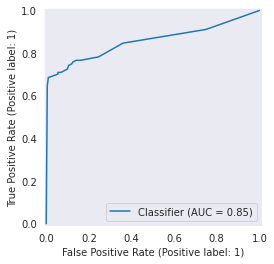

In [33]:
RocCurveDisplay.from_predictions(y_test, grid.predict_proba(X_test)[:,1])
print('Метрика f1:', f1_score(y_test, grid.predict(X_test)).round(2))
print('Метрика roc_auc:', roc_auc_score(y_test, grid.predict_proba(X_test)[:,1]).round(2))

f1 просела на 0.04. Признак переобучения, но не критичного. Площадь под roc-кривой - 0.85, очень даже неплохой результат.

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>



Успех 👍:



- pipelines + ColumnTransformer + автоподбор построены 
- 'passthrough' не забыт
- drop='first’ указан
- 2 способа масштабирование


 


<div class="alert alert-warning">



Совет 🤔:





- бывает полезно замерить время исполнения кода в ячейке, это можно сделать с помощью магической функции %%time    
    
 

- в нашем проекте мы использовали pipeline со стандартными функциями sklearn (StandardScaler, MinMaxScaler итд итп), но ведь у нас может быть своя собственная функция преобразования данных. Например мы хотим заполняем пропуски средней в какой то группировке, но должны учесть логику моделирования, по которой мы можем использовать только данные из train (делаем .fit), а затем "обученную на train функцию преобразования" используем на test/valid (делаем .transform), по ссылкам можно посмотреть как это можно реализовать [Ссылка 1](https://dzen.ru/media/id/5ee6f73b7cadb75a66e4c7e3/sozdanie-polzovatelskih-preobrazovatelei-dannyh-62b2a9a80e49941961ffc7a2),
[Ссылка 2](https://towardsdatascience.com/pipelines-custom-transformers-in-scikit-learn-the-step-by-step-guide-with-python-code-4a7d9b068156)

Обрати внимание что мы создаем для этого класс, наследуя классы TransformerMixin и BaseEstimator, чтобы можно было применять  .fit(X_train), .predict(X_test)    


    
- для расширения кругозора: GridSearch/RandomizedSearch это классика, но есть и другие варианты подбора гиперпараметров, можешь [ознакомиться](https://www.freecodecamp.org/news/hyperparameter-optimization-techniques-machine-learning/). Выделю оptuna, очень много плюсов, причем изучение можно начать с [**OptunaSearchCV**](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.integration.OptunaSearchCV.html). Интерфейс практически такой же, как у GridSearch/RandomizedSearch

    

<div class="alert alert-info">
<b>Комментарий студента</b> 
    
Добавил измерение времени кросс-валидации. 
    
Я изначально, когда понял, что GridSearch займёт слишком много времени, пытался выстроить кросс-валидацию на OptunaSearch, но насколько я понимаю, этот метод не умеет перебирать сами модели, а только их гиперпараметры. В будущем, думаю, буду запускать кросс-валидацию для каждой модели, и самостоятельно выбирать лучшую среди лучших моделей каждого типа, пока их не слишком много.
</div>


<div class="alert alert-danger">
<font size="5"><b>Комментарий ревьюера</b></font>



Ошибка ❌:






   
    
- и хорошо бы обосновать  выбор метрики    



    
- сразу после выбора лучше модели мы проводим её финальное тестирование    
    

<div class="alert alert-warning">



- По большому счёту в этом проекте подойдёт любая метрика,  но стоит обосновать выбор. Тут можно отталкиваться от того если у нас есть дисбаланс, но на самом деле от этого страдает только одна метрика (можешь сказать какая?). Поэтому лучше оттолкнуться от бизнес-постановки задачи, в частности - что нам важнее, найти как можно больше примеров нашего положительного класса, или сделать так чтобы точность прогноза нашего положительного класса была максимальной. Или нам нужно учесть оба этих параметра. Кроме того есть уникальная метрика которая не чувствительна к порогу. 



<div class="alert alert-info">
<b>Комментарий студента</b> 
    
Добавил итоговое тестирование на тестовых данных, используя f1, с которой модель обучалась, и roc_auc(Как раз та, что не чувствительна к порогу)
    
Дописал обоснование выбора метрики перед кросс-валидацией. Постарался описать её преимущества в данной ситуации, но возможно не совсем правильно понял как и под каким углом обосновывать выбор метрики.

От дисбаланса классов страдает accuracy. Она не учитывает разницу в соотношении, и выдаёт простой процент верных ответов
</div>

## Анализ важности признаков

Самое время заглянуть под капот нашей модели и выяснить, какие признаки она считает наиболее важными. Для этого мы обратимся к библиотеке shap. Для начала необходимо обучить модель на самых лучших параметрах, какие нам удалось найти.

In [34]:
model = grid.best_estimator_.named_steps['models']
X_train_se = pd.DataFrame(grid.best_estimator_.named_steps['preprocessor'].transform(X_train), columns=grid.best_estimator_.named_steps['preprocessor'].get_feature_names_out())

<div class="alert alert-danger">
<font size="5"><b>Комментарий ревьюера</b></font>



Ошибка ❌:




Это не технично опять обучать модель, ведь у тебя она уже есть. 
    
Попробуй вытащить из pipeline модель так    
    
    .best_estimator_.named_steps['models']   
    
    
А для преобразования данных использовать
    
    .named_steps['preprocessor']
	
	
	
А новые названия столбцов в правильном порядке после этапа  preprocessor вытаскиваем так
    
    
    .best_estimator_.named_steps['preprocessor'].get_feature_names_out()	
    
    
Если будут проблемы с .get_feature_names_out() обнови библиотеку: 
    
    !pip install -U scikit-learn 
   
И перезапусти ядро	
	
	
Если не получится попробуем разобраться вместе    



<div class="alert alert-info">
<b>Комментарий студента</b> 
    
Вытащил модель из пайплайна. Спасибо за подсказки! Без них-бы целый день копался в документации. Единственное что - к названиям признаков добавились названия шагов пайплайна, но обучение уже прошло и это не должно быть критично. Не баг, а фича, это даже более информативно.
</div>

Теперь загрузим модель в специально обученный explainer, и попросим сгенерировать SHAP-значения. И сразу-же выведем наглядный график. Низкие SHAP-значения склоняют модель к присвоению объекту класса 0, высокие, соответственно, к классу 1. Каждая точка - одно значение параметра, цвет отображает высоту значения.

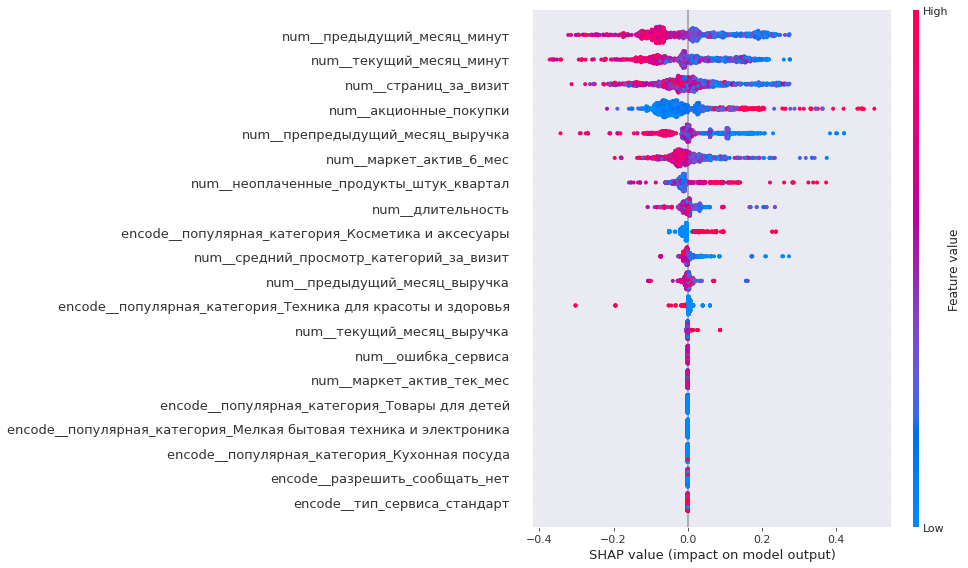

In [35]:
explainer = shap.TreeExplainer(model, X_train_se)
shap_values = explainer(X_train_se)
shap.plots.beeswarm(shap_values[:, :, 1], max_display=20)

Высокие значения времени посещения сайта, посещенных страниц за визит, выручки за позапрошлый месяц, рекламной активности и т.д склоняют модель спрогнозировать, что покупательская активность клиента останется на прежнем уровне.

Высокие значения процента акционных покупок, количества неоплаченных товаров и предпочтение в покупке косметики склоняют модель спрогнозировать, что покупательская активность клиента упадёт.

На решения модели практически никак не влияют - Ошибки сервиса, рекламная активность в текущем месяце, предпочтения в товарах для детей, мелкой бытовой технике или кухонной посуде, согласие на рассылку и тип сервиса. В будущем для повышения точности прогнозирования модели от этих признаков можно будет попробовать отказаться.

Теперь посмотрим на конкретные примеры. Возьмём 2 записи о клиентах, один из которых, по прогнозам модели, станет покупать меньше, а второй нет. Построим для каждого отдельный график.

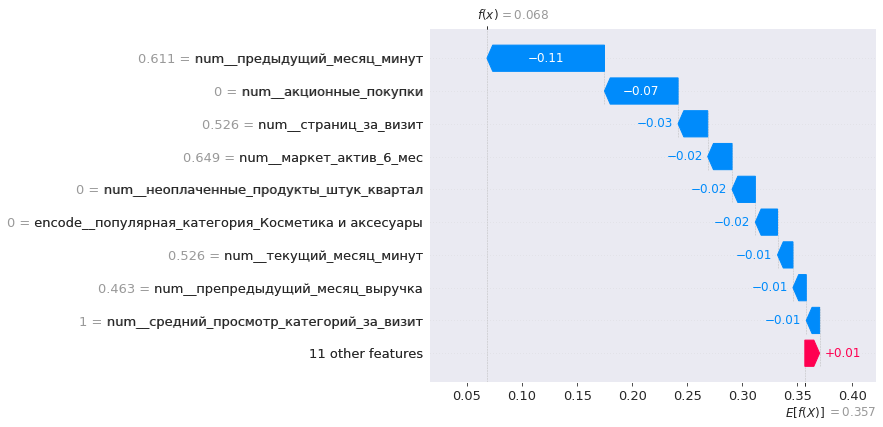

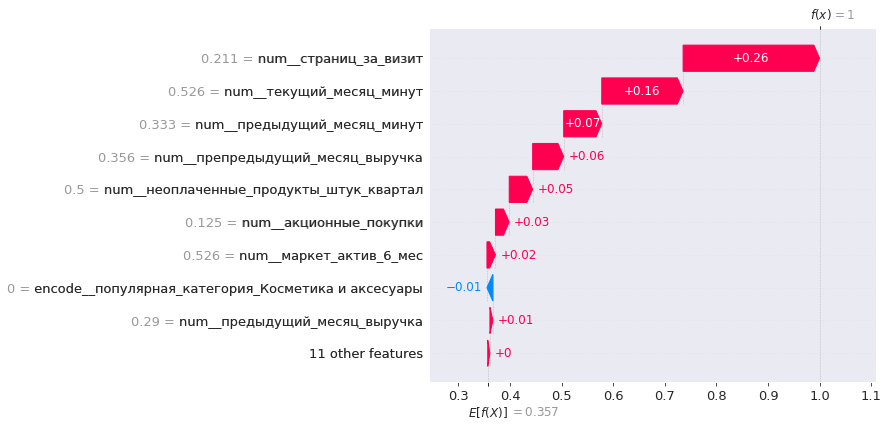

In [36]:
shap.plots.waterfall(shap_values[75, :, 1])
shap.plots.waterfall(shap_values[18, :, 1])

Одни из параметров, ожидаемо, влияют на решения модели сильнее других. При этом для разных примеров важность отдельного параметра меняется. Так, например, нулевое значение акционных покупок стоит на втором месте по важности признаков в первом примере, а во втором находится на шестом месте, со значением 0.125.

Итого, можно считать признаки, отражающие активность клиента на сайте, основополагающими для принятия решений при прогнозировании. Количество проведённых минут и количество посещённых страниц имеют наибольший вес. В целом можно сказать, что чем больше клиент проводит времени на сайте, тем меньше вероятность снижения покупательской активности.

  
    
<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>



Успех 👍:



- Построен график важности факторов, график аккуратный
    
    
- Присутствуют выводы о том, какие факторы сильнее/слабее влияют
    
	
- Плюс за использование .beeswarm    
     
    
<div class="alert alert-warning">



Совет 🤔:
   

    
	
- можно и по-другому оценить важность признаков, это можно сделать с помощью [.feature_importance](https://inria.github.io/scikit-learn-mooc/python_scripts/dev_features_importance.html) (но не забываем что в логистической регрессии надо учесть логарифм в функция ошибки). Или с помощью [Permutation Importance](https://scikit-learn.org/stable/modules/permutation_importance.html)	
	

## Сегментация покупателей

Теперь мы выделим сегмент покупателей, отдающих предпочтение акционным товарам, и чья покупательская активность снизилась в последнее время.

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>



Успех 👍:



👍


 

In [37]:
ds_new['y_pred'] = grid.predict(ds_new.drop('покупательская_активность', axis=1))
ds_new = ds_new.join(ds_mean_money.set_index('id'))
ds_new['прибыль'] = ds_new['прибыль']*1000
segment = ds_new
segment = segment[(segment['y_pred'] == 1)&(segment['акционные_покупки']>0.8)].drop('покупательская_активность', axis=1)
dataset_info(segment, False)

Количество дубликатов: 0
Длина датасета: 142


,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_выручка,текущий_месяц_минут,предыдущий_месяц_минут,y_pred,прибыль
id,,,,,,,,,,,,,,,,,,
215351,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6610.4,6158.0,13,11,1,4870.0
215352,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4594.0,5872.5,5807.5,11,8,1,4210.0
215364,премиум,да,4.3,4,708,0.98,Домашний текстиль,3,3,3,3,4942.0,5484.8,5795.5,9,11,1,2670.0
215365,стандарт,да,3.9,4,167,0.95,Техника для красоты и здоровья,6,4,2,5,4190.0,4799.3,4577.0,10,6,1,3650.0
215373,премиум,нет,3.8,3,811,0.90,Товары для детей,2,5,5,3,4293.0,5161.1,4632.0,8,10,1,3690.0


<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюера</b></font>



Совет 🤔:


    segment['покупательская активность'] == 1
    
    
    
Всё-таки считается что мы должны использовать прогнозы модели для этого    

<div class="alert alert-info">
<b>Комментарий студента</b> 
    
Поправил
</div>

Теперь посмотрим на распределение категориальных признаков в сегменте.

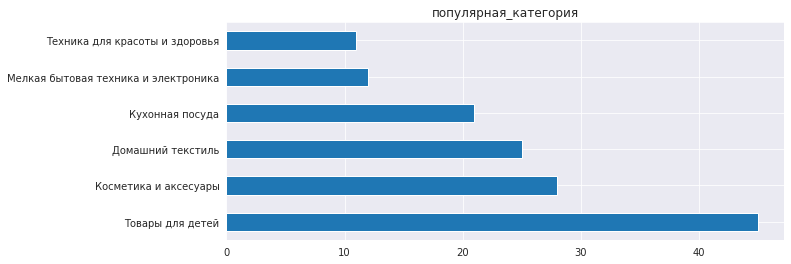

In [38]:
segment['популярная_категория'].value_counts().plot(kind='barh', title='популярная_категория', figsize=(10, 4), grid=True);

Самая популярная категория у сегмента - товары для детей. Кажется, картина начинает складываться. Дети вырастают, активность падает. Решением в данной ситуации могут стать персонализированные скидки на школьные/канцелярские товары.

Следом по популярности идёт самая рискованная категория - косметика. Она имеет наибольший вес в модели среди остальных категорий товаров, и склоняет прогноз в сторону снижения активности. Возможно, когда среди косметики не находится товаров со скидкой, покупатели уходят к конкурентам. Здесь решением может стать фокусировка на поддержании акций, чтобы в любой момент хотя-бы один товар из этой категории продавался со скидкой.

Посмотрим на различия с генеральной совокупностью.

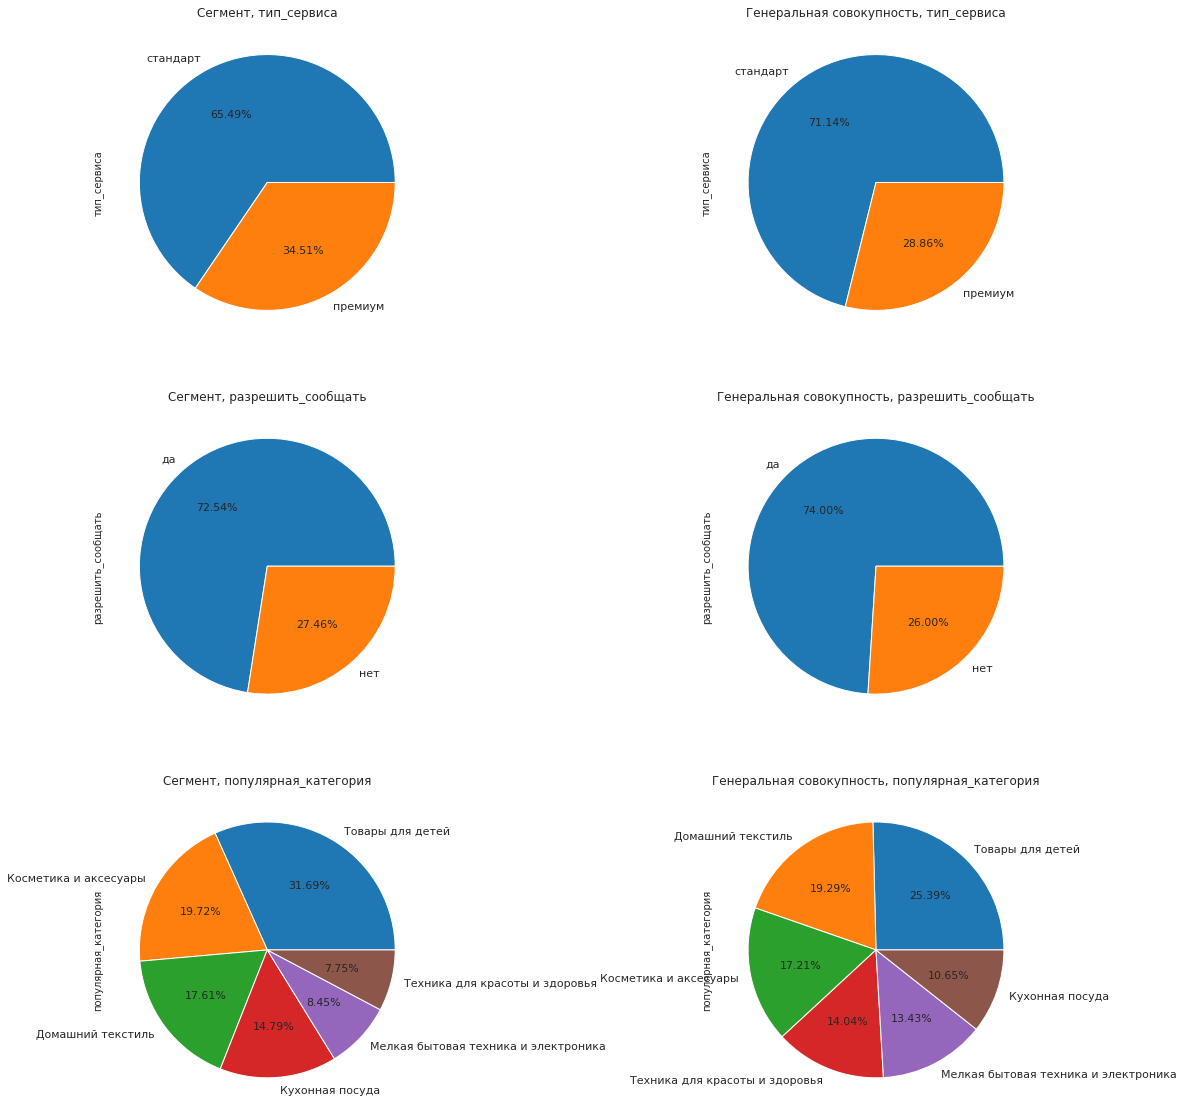

In [39]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 20))
j=0

for i in segment.select_dtypes(exclude='number').columns:
    segment[i].value_counts().plot(kind='pie', ax=axes[j, 0], autopct='%.2f%%', textprops={'fontsize': 11})
    axes[j, 0].set_title(f'Сегмент, {i}')
    ds_new[i].value_counts().plot(kind='pie', ax=axes[j, 1], autopct='%.2f%%', textprops={'fontsize': 11})
    axes[j, 1].set_title(f'Генеральная совокупность, {i}')
    j+=1
plt.show()

В сегменте немного больше процент клиентов с типом сервиса "премиум"

Также, выше процент клиентов, отдающих предпочтение товарам для детей.

Дальше взглянем на количественные признаки. Возможно, найдём какую-то закономерность.

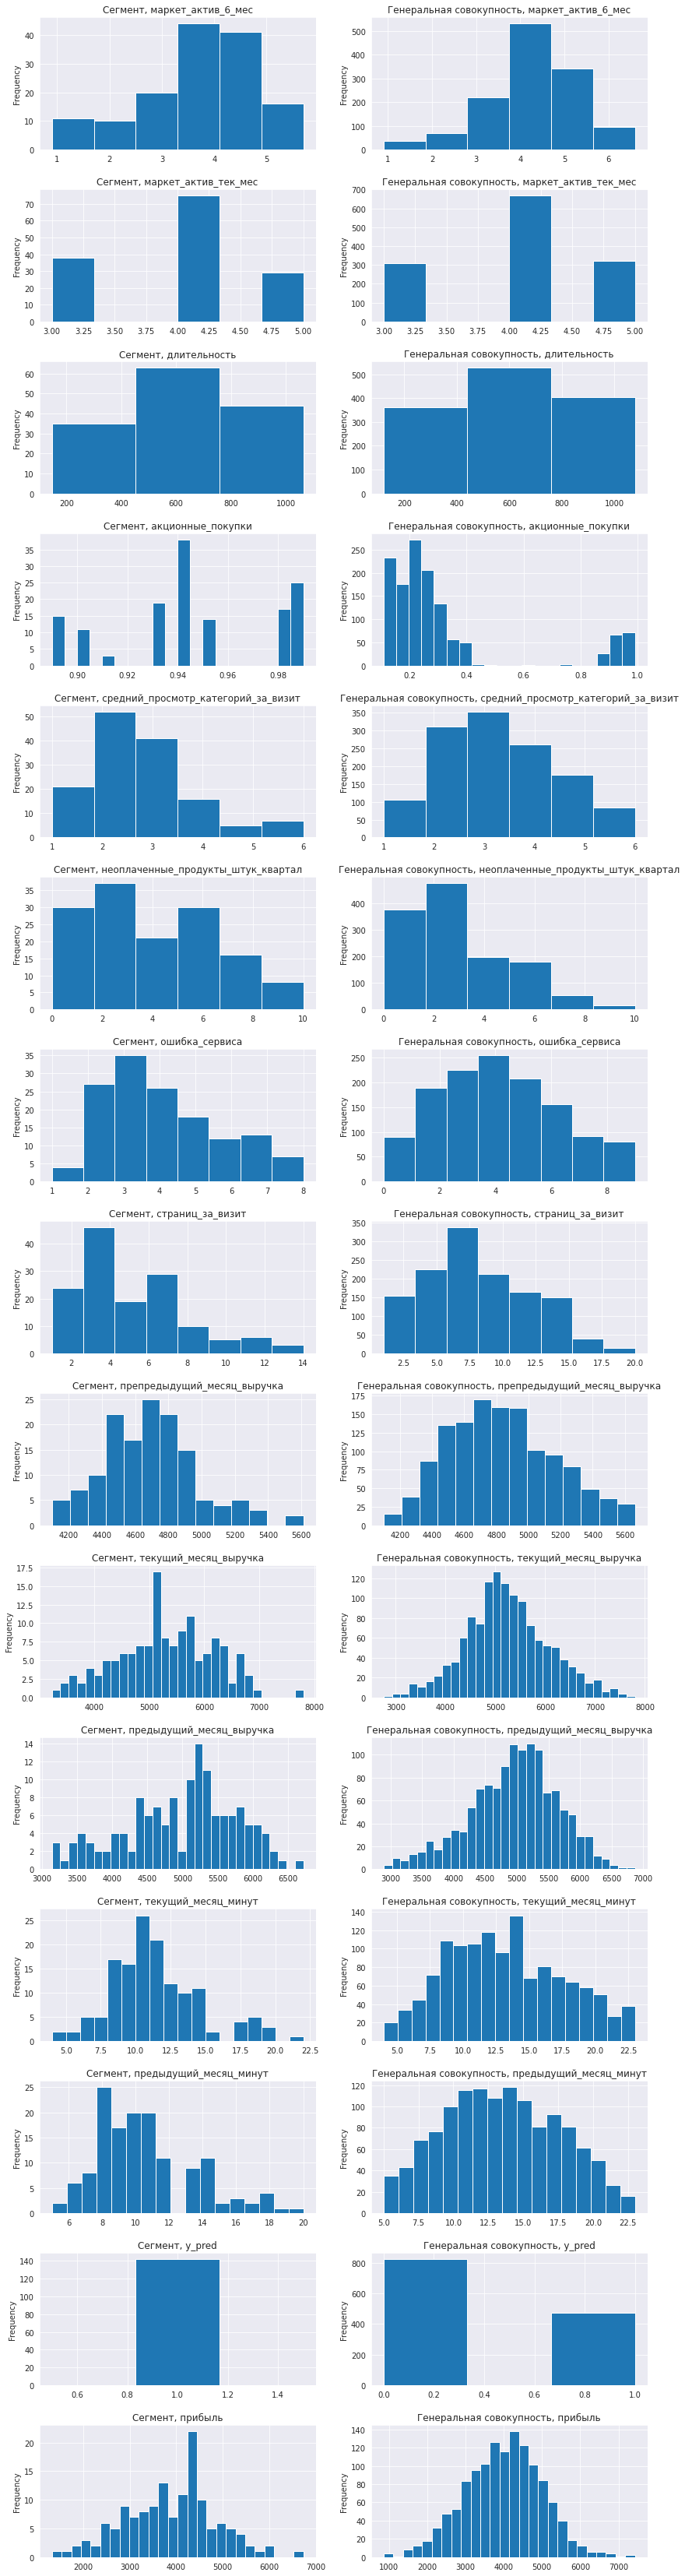

In [40]:
fig, axes = plt.subplots(nrows=15, ncols=2, figsize=(14, 60))
j=0
bins=[6, 6, 3, 20, 6, 6, 8, 8, 14, 30, 30, 18, 17, 3, 26]

for i in segment.select_dtypes(include='number').columns:
    segment[i].plot(kind='hist', ax=axes[j, 0], grid=True, bins=bins[j])
    axes[j, 0].set_title(f'Сегмент, {i}')
    ds_new[i].plot(kind='hist', ax=axes[j, 1], grid=True, bins=bins[j])
    axes[j, 1].set_title(f'Генеральная совокупность, {i}')
    j+=1
plt.subplots_adjust(wspace=0.2, hspace=0.3)
plt.show()

Кажется, покупатели из сегмента не тратят много времени на просмотр различных категорий, что, как мы помним, является тревожным звонком. Учитывая их предпочтения в акционных покупках, здесь может помочь создание подборок с акционными товарами из различных категорий. Так клиенты просмотрят больше категорий в поисках интересующих их товаров.

Точно так-же, количество страниц за визит печально мал**о**. Подборки с акционными товарами могут помочь и здесь.

Остальные распределения выборки похожи на распределения генеральной совокупности.

**Промежуточный вывод**

Итого, мы выделили сегмент покупателей, которые отдают предпочтение акционным товарам, и чья покупательская активность снизилась, и сформировали следующие предложения:
- Выдавать клиентам, покупающим в основном товары для детей, и чья активность снизилась, персонализированные скидки на школьные/канцелярские товары.
- Поддерживать наличие акционных товаров в разделе косметики и аксессуаров.
- Создавать подборки акционных товаров из различных категорий.


<div class="alert alert-danger">
<font size="5"><b>Комментарий ревьюера</b></font>



Ошибка ❌:




сами по себе цифры нас не интересуют, нас интересует разница с клиентами не попавшими в сегмент. поэтому стоит проанализировать сегмент, указать на его отличия от остальных. для этого отлично подойдут графики countplot/pie (для категориальных) и гистограмму или boxplot (для количественных), а разбивке "наш сегмент" - "не наш сегмент"

 
    

<div class="alert alert-warning">



Совет 🤔:



- А можно по-другому использовать информацию из money. Ведь самый очевидный и наверное логичный вариант - это рассмотреть сегмент клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью. Тут сходится всё - и бизнесовая составляющая, и результаты моделирования мы используем)





- Еще можно посмотреть на динамику выручки по месяцам, в группировке по группам товаров, возможно тут получится увидеть что то интересное и сделать какие то маркетинговые предложения. Отслеживание динамики, как и сравнение, отличный способ найти в данных что то интересное.


    

<div class="alert alert-info">
<b>Комментарий студента</b> 
    
Сделал 2 графика для каждого признака, по выборке и по ген. совокупности.
</div>

## Общий вывод

**Задача**

Перед нами стояла задача разработать модель, которая предскажет снижение покупательской активности клиента в следующие 3 месяца.

**Исходные данные и предобработка**

Мы работали с данными о клиентах интернет-магазина, содержащимися в нескольких таблицах - `market_file.csv`, `market_money.csv`, `market_time.csv` и `money.csv`.

В рамках предобработки, мы:
- привели названия столбцов к нижнему регистру
- исключили из данных неявный дубликат типа сервиса "стандарт"
- исправили опечатку в названии периода таблицы со временем посещения сайта

**Поиск лучшей модели**

Для того чтобы подобрать модель, которая лучше всех справится с прогнозом покупательской активности, мы:
- Использовали при подготовке данных 2 вида кодировщика и 2 вида скейлера
- Перебрали 4 вида классификационных моделей прогнозирования
- Перебрали гиперпараметры каждой модели
- Определили метрику f1_score как наиболее подходящую для оценки качества модели.

И по итогу, получили самую перспективную модель - дерево принятия решений, с максимальной глубиной 8 и минимальным числом объектов в листьях - 5. С кодировщиком OneHotEncoder и скейлером MinMaxScaler.

**Сегментация покупателей**

Был выделен сегмент покупателей с максимальным процентом акционных покупок и сниженной покупательской активностью. И были сделаны следующие выводы:
- Клиенты из сегмента отдают предпочтение категории товаров для детей и категории косметики.
- Клиенты из сегмента посещают мало категорий товаров, и мало страниц сайта.

По выводам о сегменте были сделаны предложения о персонализации скидок для клиентов, покупающих в основном товары для детей или косметику, а также о создании подборок с акционными товарами из различных категорий.


<div class="alert alert-info">
<font size="5"><b>Комментарий ревьюера</b></font>



Максим, у тебя старательно выполненная работа, все четко, осмысленно.  



Выводы подробные, в конце разделов есть промежуточные выводы.




    
Я оставил небольшие советы желтым, по желанию можешь воспользоваться
    
    
    
    
Обязательное к исправлению:



    
    
- ошибка исполнения кода
    
 
    
    
- не забываем оценить насколько приемлемо использование корреляции Пирсона (только для колличественных и для нормально распределенных)
    
    
    
- объясняем почему выбрали ту или иную метрику

    
    
- нет финального тестирования    
    



- попробуй вытащить модель из pipeline, а не обучать её заново    
    
   
    
    
- предлагаю добавить графики для "всех остальных", чтобы использовать чтобы лучше увидеть особенности в распределениях, и применить метод сравнения
    
    

 



Жду исправлений, для принятия проекта. Если какие то вопросы, то сразу спрашивай ) 
